# Tutorial 2.2: Inputs, Files, and Scans

## 2.2.0: Python Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

Please import:

In [77]:
import numpy
from IPython.display import HTML
from matplotlib import pyplot as plt

from mbfit.utils.filesystem import Directory
from mbfit.utils.job_manager import SLURMJobManager, JobManager
from mbfit.calculator import QchemCalculator, OrcaCalculator

from mbfit.system.system_like import BondType
from mbfit.system.definition import BasicFragmentDefinition, BasicCompoundDefinition, AtomDefinition, BondDefinition
from mbfit.system.initializer import VSEPRInitializer
from mbfit.system.descriptor import fragment_definition_to_xyz, compound_definition_to_xyz, compound_to_xyz, compound_to_commented_xyz
from mbfit.system.parser import xyz_to_compound_definition, xyz_to_compound_definition, xyz_to_compound_by_definition
from mbfit.system import BasicCompound
from mbfit.system.transformer import SystemTransformer
from mbfit.system.copier import CompoundCopier
from mbfit.system.transformer import make_scan
from mbfit.system.region import BasicMutableRegionManager
from mbfit.visualization import render_system, render_systems
from mbfit.visualization import plot_scan
from mbfit.utils import constants

from mbfit.system.descriptor.energy_decomposition_comment_line_descriptor import EnergyDecompositionCommentLineDescriptor

from mbfit.calculator import calculate_energy, calculate_energies

## 2.2.1 Directory Structure & File Paths

In this section, we we will setup the directory structure and file paths we will use in this notebook. Throughout this notebook, the following files will be created:

In [3]:
tutorial_2_workdir = Directory("Tutorial_2_workdir")
tutorial_2_workdir.create()

In [4]:
definitions_dir = tutorial_2_workdir.sub_directory("definitions")
definitions_dir.create()

In [5]:
fragment_CH3NH2_definition_path = definitions_dir.file("fragment_CH3NH2.def")
fragment_H2O_definition_path = definitions_dir.file("fragment_H2O.def")

In [6]:
monomer_CH3NH2_definition_path = definitions_dir.file("monomer_CH3NH2.def")
monomer_H2O_definition_path = definitions_dir.file("monomer_H2O.def")
dimer_CH3NH2_H2O_definition_path = definitions_dir.file("dimer_CH3NH2_H2O.def")
trimer_CH3NH2_H2O_H2O_definition_path = definitions_dir.file("trimer_CH3NH2_H2O_H2O.def")

In [7]:
structures_dir = tutorial_2_workdir.sub_directory("structures")
structures_dir.create()

In [8]:
monomer_CH3NH2_initial_structure_path = structures_dir.file("monomer_CH3NH2_initial_structure.xyz")
monomer_H2O_initial_structure_path = structures_dir.file("monomer_H2O_initial_structure.xyz")

monomer_CH3NH2_minimum_structure_path = structures_dir.file("monomer_CH3NH2_minimum_structure.xyz")
monomer_H2O_minimum_structure_path = structures_dir.file("monomer_H2O_minimum_structure.xyz")

In [9]:
scans_dir = tutorial_2_workdir.sub_directory("scans")
scans_dir.create()

In [10]:
scan_2b_1_path = scans_dir.file("scan_2b_1.xyz")
scan_2b_2_path = scans_dir.file("scan_2b_2.xyz")
scan_2b_3_path = scans_dir.file("scan_2b_3.xyz")

scan_3b_1_path = scans_dir.file("scan_3b_1.xyz")
scan_3b_2_path = scans_dir.file("scan_3b_2.xyz")
scan_3b_3_path = scans_dir.file("scan_3b_3.xyz")

In [11]:
scan_2b_energies_1_path = scans_dir.file("scan_2b_1.xyz")
scan_2b_energies_2_path = scans_dir.file("scan_2b_2.xyz")
scan_2b_energies_3_path = scans_dir.file("scan_2b_3.xyz")

scan_3b_energies_1_path = scans_dir.file("scan_3b_1.xyz")
scan_3b_energies_2_path = scans_dir.file("scan_3b_2.xyz")
scan_3b_energies_3_path = scans_dir.file("scan_3b_3.xyz")

In [12]:
logs_dir = tutorial_2_workdir.sub_directory("logs")
logs_dir.create()

In [13]:
jobs_dir = tutorial_2_workdir.sub_directory("jobs")
jobs_dir.create()

In [14]:
restart_dir = tutorial_2_workdir.sub_directory("restart")
restart_dir.create()

In [15]:
qchem_job_template="""
module load cpu/0.15.4  gcc/10.2.0  mvapich2/2.3.6 qchem/5.4
conda activate p310
cd ~/software/development/MB-Fit_versions/QDMS_2025
export MBFIT_HOME=$PWD
source sourceme.sh
cd -

export QCSCRATCH=/expanse/lustre/scratch/$USER/temp_project/qscratch
export QCLOCALSCR=/scratch/$USER/job_$SLURM_JOB_ID

"""

def get_qchem_job_manager(job_scratch_directory: Directory) -> JobManager:
    job_scratch_directory.create()
    return SLURMJobManager(
            input_path=f"{job_scratch_directory}/job.in",
            output_path=f"{job_scratch_directory}/job.out",
            log_path=f"{job_scratch_directory}/job.log",
            job_path=f"{job_scratch_directory}/job.job",
            job_output_path=f"{job_scratch_directory}/job.stdout",
            job_error_path=f"{job_scratch_directory}/job.stderr",
            max_queue_size=10,
            job_name="slurm_job_manager",
            allocation="csd888",
            reservation=None,
            partition="shared",
            qos=None,
            max_walltime_minutes=60,
            nodes=1,
            tasks=1,
            processors_per_task=32,
            template=qchem_job_template
    )

In [16]:
orca_job_template="""
module load cpu/0.17.3b  gcc/10.2.0/npcyll4  openmpi/4.1.1/ygduf2r
module load orca/5.0.4
export ORCA_SCRATCH=/scratch/$USER/job_$SLURM_JOB_ID
conda activate p310
cd ~/software/development/MB-Fit_versions/QDMS_2025
export MBFIT_HOME=$PWD
source sourceme.sh
cd -
"""

def get_orca_job_manager(job_scratch_directory: Directory) -> JobManager:
    job_scratch_directory.create()
    return SLURMJobManager(
            input_path=f"{job_scratch_directory}/job.in",
            output_path=f"{job_scratch_directory}/job.out",
            log_path=f"{job_scratch_directory}/job.log",
            job_path=f"{job_scratch_directory}/job.job",
            job_output_path=f"{job_scratch_directory}/job.stdout",
            job_error_path=f"{job_scratch_directory}/job.stderr",
            max_queue_size=10,
            job_name="slurm_job_manager",
            allocation="csd888",
            reservation=None,
            partition="shared",
            qos=None,
            max_walltime_minutes=60,
            nodes=1,
            tasks=32,
            processors_per_task=1,
            template=orca_job_template
    )

## 2.2.x Create `.def` definition files

First, we will create the two fragment definition files. First, the definition for the CH3NH2 fragment:

In [17]:
fragment_CH3NH2_definition = BasicFragmentDefinition()
CA  = fragment_CH3NH2_definition.add_atom(AtomDefinition("C", "A"))
HB1 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "B"))
HB2 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "B"))
HB3 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "B"))
NC  = fragment_CH3NH2_definition.add_atom(AtomDefinition("N", "C"))
HD1 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "D"))
HD2 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "D"))
fragment_CH3NH2_definition.add_bond(CA, HB1, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(CA, HB2, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(CA, HB3, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(CA, NC, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(NC, HD1, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(NC, HD2, BondDefinition(BondType.SINGLE))

fragment_definition_to_xyz.writer(fragment_CH3NH2_definition_path, fragment_CH3NH2_definition)

The definition for the H2O fragment:

In [18]:
fragment_H2O_definition = BasicFragmentDefinition()
OE  = fragment_H2O_definition.add_atom(AtomDefinition("O", "E"))
HF1 = fragment_H2O_definition.add_atom(AtomDefinition("H", "F"))
HF2 = fragment_H2O_definition.add_atom(AtomDefinition("H", "F"))
fragment_H2O_definition.add_bond(OE, HF1, BondDefinition(BondType.SINGLE))
fragment_H2O_definition.add_bond(OE, HF2, BondDefinition(BondType.SINGLE))

fragment_definition_to_xyz.writer(fragment_H2O_definition_path, fragment_H2O_definition)

Next, we will make three n-mer definitions.

First, the CH3NH2 monomer, which has a single CH3NH2 fragment.

In [19]:
monomer_CH3NH2_definition = BasicCompoundDefinition()
monomer_CH3NH2_definition.add_fragment(fragment_CH3NH2_definition)

compound_definition_to_xyz.writer(monomer_CH3NH2_definition_path, monomer_CH3NH2_definition)

First, the H2O monomer, which has a single CH3NH2 fragment.

In [20]:
monomer_H2O_definition = BasicCompoundDefinition()
monomer_H2O_definition.add_fragment(fragment_H2O_definition)

compound_definition_to_xyz.writer(monomer_H2O_definition_path, monomer_H2O_definition)

Next, the CH3NH2 -- H2O dimer, with two fragments:

In [21]:
dimer_CH3NH2_H2O_definition = BasicCompoundDefinition()
dimer_CH3NH2_H2O_definition.add_fragment(fragment_CH3NH2_definition)
dimer_CH3NH2_H2O_definition.add_fragment(fragment_H2O_definition)

compound_definition_to_xyz.writer(dimer_CH3NH2_H2O_definition_path, dimer_CH3NH2_H2O_definition)

Finally, the CH3NH2 -- H2O -- H2O trimer, with three fragments:

In [22]:
trimer_CH3NH2_H2O_H2O_definition = BasicCompoundDefinition()
trimer_CH3NH2_H2O_H2O_definition.add_fragment(fragment_CH3NH2_definition)
trimer_CH3NH2_H2O_H2O_definition.add_fragment(fragment_H2O_definition)
trimer_CH3NH2_H2O_H2O_definition.add_fragment(fragment_H2O_definition)

compound_definition_to_xyz.writer(trimer_CH3NH2_H2O_H2O_definition_path, trimer_CH3NH2_H2O_H2O_definition)

We will use these definition files throughout Tutorial 2.

## 2.2.x Geometry Initialization

Next, we need a reasonable initial guess for the structure of our monomer. The guess need only be good enough that it will covnerge to the actual minimum structure when we perform a minimization with DFT. MB-Fit contains the class `VESPRInitializer`, which will make a reasonable guess about the structure of a molecule based on its bonding topology. Let's use `VESPRInitializer` to create an initial structure file:

In [23]:
system_initializer = VSEPRInitializer(seed=12345)

In [24]:
definition = xyz_to_compound_definition.reader(monomer_CH3NH2_definition_path)
initial_structure_CH3NH2 = system_initializer(definition)
compound_to_xyz.writer(monomer_CH3NH2_initial_structure_path, initial_structure_CH3NH2)

Initializing compound C1H3N1H2
System initialization complete!


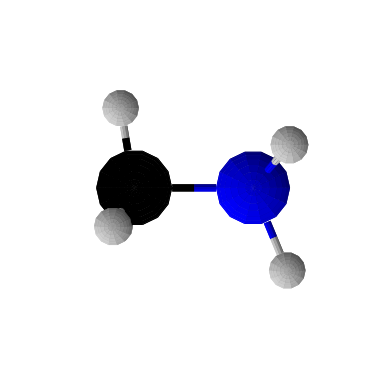

In [25]:
fig = render_system(
        initial_structure_CH3NH2,
        center=initial_structure_CH3NH2.atoms[0].point,
        alignment=((initial_structure_CH3NH2.atoms[4].point-initial_structure_CH3NH2.atoms[0].point), (initial_structure_CH3NH2.atoms[3].point-initial_structure_CH3NH2.atoms[0].point))
)
fig

In [26]:
definition = xyz_to_compound_definition.reader(monomer_H2O_definition_path)
initial_structure_H2O = system_initializer(definition)
compound_to_xyz.writer(monomer_H2O_initial_structure_path, initial_structure_H2O)

Initializing compound O1H2
System initialization complete!


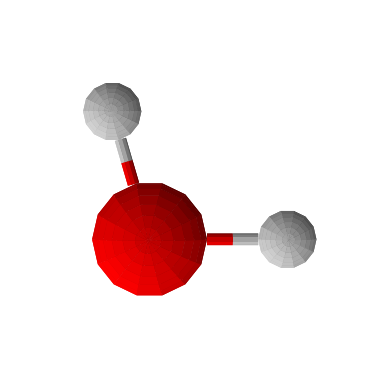

In [94]:
fig = render_system(
        initial_structure_H2O,
        center=initial_structure_H2O.atoms[0].point,
        alignment=((initial_structure_H2O.atoms[1].point-initial_structure_H2O.atoms[0].point), (initial_structure_H2O.atoms[2].point-initial_structure_H2O.atoms[0].point))
)
fig

## 2.2.x Geometry Minimization

That guess is looking a little rough, lets optimize it using electronic structure theory. While the PEF will be developed at the CCSD(T) level of theory, its not important that the geometry optimization be at the same level of theory as the reference energies will be calculated at, so lets use something cheaper like a high-quality DFT functional.

In [54]:
calculator = QchemCalculator("wB97M-V", "AUG-cc-pVTZ", log_directory="{logs_dir}")

In [14]:
definition = xyz_to_compound_definition.reader("{monomer_CH3NH2_definition_path}")
initial_structure = xyz_to_compound_by_definition(definition).reader("{monomer_CH3NH2_initial_structure_path}")
minimized_structure, minimized_DFT_energy = minimize_structure(
        initial_structure,
        calculator=calculator,
        job_manager=get_job_manager()
)
compound_to_xyz.writer("{monomer_CH3NH2_minimum_structure_path}", minimized_structure)

In [48]:
job = job_runner.queue_job("CH3NH2_minimization",
f"""
from mbfit.calculator import QchemCalculator
from mbfit.system.parser import xyz_to_compound_definition, xyz_to_compound_by_definition
from mbfit.system.descriptor import compound_to_xyz

calculator = QchemCalculator("wB97M-V", "AUG-cc-pVTZ", log_directory="{logs_dir}")
definition = xyz_to_compound_definition.reader("{monomer_CH3NH2_definition_path}")
initial_structure = xyz_to_compound_by_definition(definition).reader("{monomer_CH3NH2_initial_structure_path}")
optimized_structure, optimized_energy, optimization_log_path = calculator.optimize(initial_structure, num_threads=16, mem_mb=32000)
compound_to_xyz.writer("{monomer_CH3NH2_minimum_structure_path}", optimized_structure)
"""
)

print("Minimization job has been queued")

job.wait_until_started()

print("Minimization job has started execution")
job.wait_until_done()

print("Minimization job is done!")

Minimization job has been queued
Minimization job has started execution
Minimization job is done!


In [49]:
job = job_runner.queue_job("H2O_minimization",
f"""
from mbfit.calculator import QchemCalculator
from mbfit.system.parser import xyz_to_compound_definition, xyz_to_compound_by_definition
from mbfit.system.descriptor import compound_to_xyz

calculator = QchemCalculator("wB97M-V", "AUG-cc-pVTZ", log_directory="{logs_dir}")
definition = xyz_to_compound_definition.reader("{monomer_H2O_definition_path}")
initial_structure = xyz_to_compound_by_definition(definition).reader("{monomer_H2O_initial_structure_path}")
optimized_structure, optimized_energy, optimization_log_path = calculator.optimize(initial_structure, num_threads=16, mem_mb=32000)
compound_to_xyz.writer("{monomer_H2O_minimum_structure_path}", optimized_structure)
"""
)

print("Minimization job has been queued")

job.wait_until_started()

print("Minimization job has started execution")
job.wait_until_done()

print("Minimization job is done!")

Minimization job has been queued
Minimization job has started execution
Minimization job is done!


How calculate the CCSD(T) energies:

In [145]:
job = orca_runner.queue_job("CH3NH2_minimum_energy_calculation",
f"""
from mbfit.calculator import OrcaCalculator
from mbfit.system.parser import xyz_to_compound_definition, xyz_to_compound_by_definition
from mbfit.system.descriptor import compound_to_xyz

calculator = OrcaCalculator("DLPNO-CCSD(T)-F12", "cc-pVTZ-F12", log_directory="{logs_dir}", command_line_args = ["VeryTightSCF", "TightPNO", "PModel"], basis_args = {{"AuxC": "cc-pVTZ/C", "CABS": "cc-pVTZ-F12-CABS"}})
definition = xyz_to_compound_definition.reader("{monomer_CH3NH2_definition_path}")
optimized_structure = xyz_to_compound_by_definition(definition).reader("{monomer_CH3NH2_minimum_structure_path}")
optimized_energy, optimization_log_path = calculator.energy(initial_structure, num_threads=16, mem_mb=32000)
compound_to_xyz.writer("{monomer_CH3NH2_minimum_structure_path}", optimized_structure)
"""
)

print("Minimization job has been queued")

job.wait_until_started()

print("Minimization job has started execution")
job.wait_until_done()

print("Minimization job is done!")

Minimization job has been queued
Minimization job has started execution
Minimization job is done!


In [ ]:
job = orca_runner.queue_job("CH3NH2_minimum_energy_calculation",
f"""
from mbfit.calculator import OrcaCalculator
from mbfit.system.parser import xyz_to_compound_definition, xyz_to_compound_by_definition
from mbfit.system.descriptor import compound_to_xyz

calculator = OrcaCalculator("DLPNO-CCSD(T)-F12", "cc-pVTZ-F12", log_directory="{logs_dir}", command_line_args = ["VeryTightSCF", "TightPNO", "PModel"], basis_args = {{"AuxC": "cc-pVTZ/C", "CABS": "cc-pVTZ-F12-CABS"}})
definition = xyz_to_compound_definition.reader("{monomer_H2O_definition_path}")
optimized_structure = xyz_to_compound_by_definition(definition).reader("{monomer_H2O_minimum_structure_path}")
optimized_energy, optimization_log_path = calculator.energy(initial_structure, num_threads=16, mem_mb=32000)
compound_to_xyz.writer("{monomer_H2O_minimum_structure_path}", optimized_structure)
"""
)

print("Minimization job has been queued")

job.wait_until_started()

print("Minimization job has started execution")
job.wait_until_done()

print("Minimization job is done!")

## 2.2.2 Two-Body Scans

Now we make a few two-body scans. We will use these during future steps to validate the quality of the 2-body parts of the PEF.

Lets generate a few 2-body CH$_3$-NH$_2$ -- H$_2$O scans. We will make three scans.

In [28]:
dimer_CH3NH2_H2O_definition = xyz_to_compound_definition.reader(dimer_CH3NH2_H2O_definition_path)
dimer_CH3NH2_H2O = BasicCompound(dimer_CH3NH2_H2O_definition)

dimer_CH3NH2_H2O.fragments[0].set_xyz(monomer_CH3NH2_initial_structure_path)
dimer_CH3NH2_H2O.fragments[1].set_xyz(monomer_H2O_initial_structure_path)

monomer_CH3NH2 = dimer_CH3NH2_H2O.fragments[0]
monomer_H2O = dimer_CH3NH2_H2O.fragments[1]

H-bond between H on -NH$_2$ and O in H$_2$O:

In [29]:
scan_2b_1 = make_scan(
        system=dimer_CH3NH2_H2O,
        region1=monomer_CH3NH2,
        region2=monomer_H2O,
        center1=monomer_CH3NH2.atoms[5].point,
        center2=monomer_H2O.atoms[0].point,
        align1=[monomer_CH3NH2.atoms[5].point-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[5].point-monomer_CH3NH2.atoms[0].point],
        align2=[monomer_H2O.atoms[1].point-monomer_H2O.atoms[0].point + monomer_H2O.atoms[2].point-monomer_H2O.atoms[0].point, monomer_H2O.atoms[1].point - monomer_H2O.atoms[0].point],
        distances=numpy.arange(1.0, 10.5, 0.5)
)

compound_to_xyz.descriptor_sequence().writer(scan_2b_1_path, scan_2b_1)

In [30]:
HTML(render_systems(
        scan_2b_1,
        center=scan_2b_1[0].atoms[4].point,
        alignment=((scan_2b_1[0].atoms[7].point-scan_2b_1[0].atoms[4].point), (scan_2b_1[0].atoms[0].point-scan_2b_1[0].atoms[4].point))
).to_jshtml())

H-bond between H on H$_2$O and N in -NH$_2$:

In [31]:
scan_2b_2 = make_scan(
        system=dimer_CH3NH2_H2O,
        region1=monomer_CH3NH2,
        region2=monomer_H2O,
        center1=monomer_CH3NH2.atoms[4].point,
        center2=monomer_H2O.atoms[1].point,
        align1=(monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[0].point + monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[5].point + monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[6].point, monomer_CH3NH2.atoms[0].point-monomer_CH3NH2.atoms[4].point),
        align2=(monomer_H2O.atoms[0].point-monomer_H2O.atoms[1].point, monomer_H2O.atoms[2].point-monomer_H2O.atoms[1].point),
        distances=numpy.arange(1.0, 10.5, 0.5)
)

compound_to_xyz.descriptor_sequence().writer(scan_2b_2_path, scan_2b_2)

In [32]:
HTML(render_systems(
        scan_2b_2,
        center=scan_2b_2[0].atoms[4].point,
        alignment=((scan_2b_2[0].atoms[7].point-scan_2b_2[0].atoms[4].point), (scan_2b_2[0].atoms[0].point-scan_2b_2[0].atoms[4].point))
).to_jshtml())

H from -CH$_3$ approaching O in H$_2$O

In [33]:
scan_2b_3 = make_scan(
        system=dimer_CH3NH2_H2O,
        region1=monomer_CH3NH2,
        region2=monomer_H2O,
        center1=monomer_CH3NH2.atoms[1].point,
        center2=monomer_H2O.atoms[0].point,
        align1=(monomer_CH3NH2.atoms[1].point-monomer_CH3NH2.atoms[0].point, monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[1].point),
        align2=(monomer_H2O.atoms[1].point-monomer_H2O.atoms[0].point + monomer_H2O.atoms[2].point-monomer_H2O.atoms[0].point, monomer_H2O.atoms[1].point-monomer_H2O.atoms[0].point),
        distances=numpy.arange(1.0, 10.5, 0.5)
)

compound_to_xyz.descriptor_sequence().writer(scan_2b_3_path, scan_2b_3)

In [34]:
HTML(render_systems(
        scan_2b_3,
        center=scan_2b_3[0].atoms[0].point,
        alignment=((scan_2b_3[0].atoms[7].point-scan_2b_3[0].atoms[0].point), (scan_2b_3[0].atoms[4].point-scan_2b_3[0].atoms[0].point))
).to_jshtml())

Now, lets perform the reference calculations for the scans.

In [35]:
# calculator = OrcaCalculator("DLPNO-CCSD(T)-F12", "cc-pVTZ-F12", log_directory="test_logs", command_line_args = ["VeryTightSCF", "TightPNO", "PModel"], basis_args = {"AuxC": "cc-pVTZ/C", "CABS": "cc-pVTZ-F12-CABS"})
calculator = QchemCalculator("HF", "STO-3G", log_directory=f"{logs_dir}")

In [36]:
energies_2b_1 = calculate_energies(scan_2b_1, calculator, get_qchem_job_manager(jobs_dir), restart_dir.file("energies_2b_1.restart"), 16, 32000)
compound_to_commented_xyz.descriptor_sequence().writer(scan_2b_energies_1_path, list(zip(scan_2b_1, EnergyDecompositionCommentLineDescriptor().sequence()(energies_2b_1))))

Waiting for JobManager to begin running...
Running energy calculations |====================================================================================================| - 19/19
Completed n-mer energy calculations!


In [37]:
energies_2b_2 = calculate_energies(scan_2b_2, calculator, get_qchem_job_manager(jobs_dir), restart_dir.file("energies_2b_2.restart"), 16, 32000)
compound_to_commented_xyz.descriptor_sequence().writer(scan_2b_energies_2_path, list(zip(scan_2b_2, EnergyDecompositionCommentLineDescriptor().sequence()(energies_2b_2))))

Waiting for JobManager to begin running...
Running energy calculations |====================================================================================================| - 19/19
Completed n-mer energy calculations!


In [38]:
energies_2b_3 = calculate_energies(scan_2b_3, calculator, get_qchem_job_manager(jobs_dir), restart_dir.file("energies_2b_3.restart"), 16, 32000)
compound_to_commented_xyz.descriptor_sequence().writer(scan_2b_energies_3_path, list(zip(scan_2b_3, EnergyDecompositionCommentLineDescriptor().sequence()(energies_2b_3))))

Waiting for JobManager to begin running...
Running energy calculations |====================================================================================================| - 19/19
Completed n-mer energy calculations!


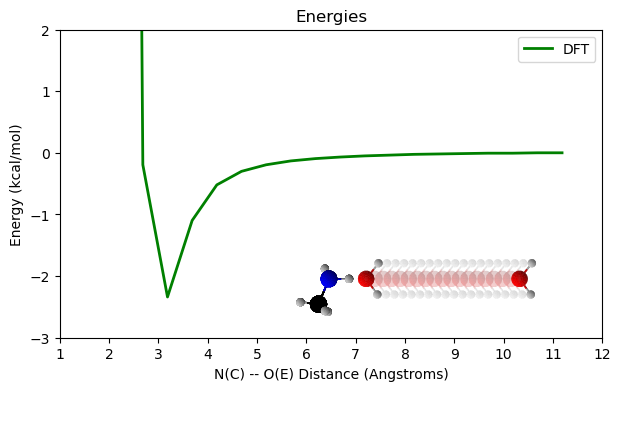

In [99]:
plot_scan(
        scan_2b_1,
        {"DFT": [(e[(0, 1)] - energies_2b_1[-1][(0,1)])*constants.au_to_kcal for e in energies_2b_1]},
        4,
        7,
        title="Energies",
        ymax=2
)

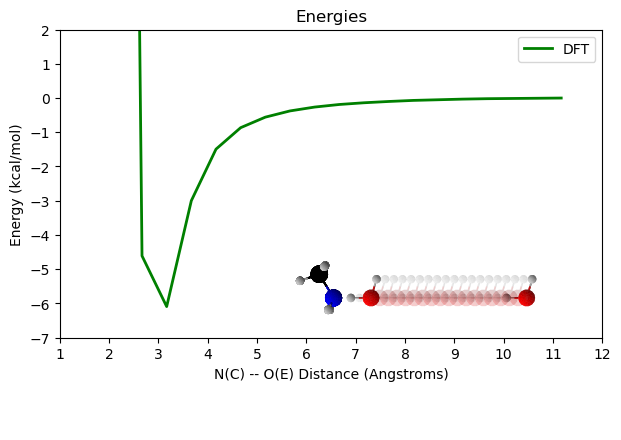

In [100]:
plot_scan(
        scan_2b_2,
        {"DFT": [(e[(0, 1)] - energies_2b_2[-1][(0,1)])*constants.au_to_kcal for e in energies_2b_2]},
        4,
        7,
        title="Energies",
        ymax=2
)

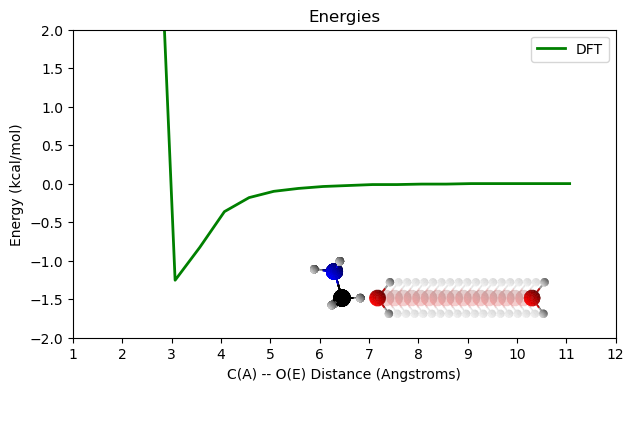

In [101]:
plot_scan(
        scan_2b_3,
        {"DFT": [(e[(0, 1)] - energies_2b_3[-1][(0,1)])*constants.au_to_kcal for e in energies_2b_3]},
        0,
        7,
        title="Energies",
        ymax=2
)

## 2.2.3 Three-Body Scans

Now we make a few three-body scans. We will use these during future steps to validate the quality of the 2-body parts of the PEF.

Lets also consider a few 3-body structures. We will make three scans.

In [80]:
trimer_CH3NH2_H2O_definition = xyz_to_compound_definition.reader(trimer_CH3NH2_H2O_H2O_definition_path)
trimer_CH3NH2_H2O = BasicCompound(trimer_CH3NH2_H2O_definition)

trimer_CH3NH2_H2O.fragments[0].set_xyz(monomer_CH3NH2_initial_structure_path)
trimer_CH3NH2_H2O.fragments[1].set_xyz(monomer_H2O_initial_structure_path)
trimer_CH3NH2_H2O.fragments[2].set_xyz(monomer_H2O_initial_structure_path)

monomer_CH3NH2 = trimer_CH3NH2_H2O.fragments[0]
monomer_H2O_1 = trimer_CH3NH2_H2O.fragments[1]
monomer_H2O_2 = trimer_CH3NH2_H2O.fragments[2]

dimer = BasicMutableRegionManager(trimer_CH3NH2_H2O).make_region([monomer_CH3NH2, monomer_H2O_1])
transformer1 = SystemTransformer(monomer_CH3NH2)
transformer2 = SystemTransformer(monomer_H2O_1)

-NH$_2$ donating 2 H-bonds to 2 H$_2$Os, where one H$_2$O moves away:

In [81]:
transformer1.translate(translation=-monomer_CH3NH2.atoms[5].point)
transformer2.translate(translation=-monomer_H2O_1.atoms[0].point)
transformer1.align(vectors_to_align=[-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[0].point])
transformer2.align(vectors_to_align=[monomer_H2O_1.atoms[1].point + monomer_H2O_1.atoms[2].point, monomer_H2O_1.atoms[1].point])

# Make fixed H-bond 2.0 A long
transformer2.translate(x=2.0)

scan_3b_1 = make_scan(
        system=trimer_CH3NH2_H2O,
        region1=dimer,
        region2=monomer_H2O_2,
        center1=monomer_CH3NH2.atoms[6].point,
        center2=monomer_H2O_2.atoms[0].point,
        align1=[monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[0].point],
        align2=[monomer_H2O_2.atoms[1].point-monomer_H2O_2.atoms[0].point + monomer_H2O_2.atoms[2].point-monomer_H2O_2.atoms[0].point, monomer_H2O_2.atoms[1].point - monomer_H2O_2.atoms[0].point],
        distances=numpy.arange(1.0, 10.5, 0.5)
)

compound_to_xyz.descriptor_sequence().writer(scan_3b_1_path, scan_3b_1)

In [82]:
HTML(render_systems(
        scan_3b_1,
        center=scan_3b_1[0].atoms[4].point,
        alignment=((scan_3b_1[0].atoms[-3].point-scan_3b_1[0].atoms[4].point), (scan_3b_1[0].atoms[0].point-scan_3b_1[0].atoms[4].point))
).to_jshtml())

-NH$_2$ donating 1 H-bond and accepting 1 H-bond, where the H$_2$O that is accepting an H-bond moves away.

In [83]:
transformer1.translate(translation=-monomer_CH3NH2.atoms[4].point)
transformer2.translate(translation=-monomer_H2O_1.atoms[1].point)
transformer1.align(vectors_to_align=[-monomer_CH3NH2.atoms[5].point-monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[0].point, monomer_CH3NH2.atoms[0].point])
transformer2.align(vectors_to_align=[monomer_H2O_1.atoms[0].point, monomer_H2O_1.atoms[2].point])

# Make fixed H-bond 2.0 A long
transformer2.translate(x=2.0)

scan_3b_2 = make_scan(
        system=trimer_CH3NH2_H2O,
        region1=dimer,
        region2=monomer_H2O_2,
        center1=monomer_CH3NH2.atoms[6].point,
        center2=monomer_H2O_2.atoms[0].point,
        align1=[monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[0].point],
        align2=[monomer_H2O_2.atoms[1].point-monomer_H2O_2.atoms[0].point + monomer_H2O_2.atoms[2].point-monomer_H2O_2.atoms[0].point, monomer_H2O_2.atoms[1].point - monomer_H2O_2.atoms[0].point],
        distances=numpy.arange(1.0, 10.5, 0.5)
)

compound_to_xyz.descriptor_sequence().writer(scan_3b_2_path, scan_3b_2)

In [84]:
HTML(render_systems(
        scan_3b_2,
        center=scan_3b_2[0].atoms[4].point,
        alignment=((scan_3b_2[0].atoms[-3].point-scan_3b_2[0].atoms[4].point), (scan_3b_2[0].atoms[0].point-scan_3b_2[0].atoms[4].point))
).to_jshtml())

-NH$_2$ donating 1 H-bond and accepting 1 H-bond, where the H$_2$O that is donating an H-bond moves away.

In [85]:
transformer1.translate(translation=-monomer_CH3NH2.atoms[5].point)
transformer2.translate(translation=-monomer_H2O_1.atoms[0].point)
transformer1.align(vectors_to_align=[-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[0].point])
transformer2.align(vectors_to_align=[monomer_H2O_1.atoms[1].point + monomer_H2O_1.atoms[2].point, monomer_H2O_1.atoms[1].point])

# Make fixed H-bond 2.0 A long
transformer2.translate(x=2.0)

scan_3b_3 = make_scan(
        system=trimer_CH3NH2_H2O,
        region1=dimer,
        region2=monomer_H2O_2,
        center1=monomer_CH3NH2.atoms[4].point,
        center2=monomer_H2O_2.atoms[1].point,
        align1=[monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[5].point + monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[6].point + monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[0].point, monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[0].point],
        align2=[monomer_H2O_2.atoms[0].point-monomer_H2O_2.atoms[1].point, monomer_H2O_2.atoms[2].point - monomer_H2O_2.atoms[0].point],
        distances=numpy.arange(1.0, 10.5, 0.5)
)

compound_to_xyz.descriptor_sequence().writer(scan_3b_3_path, scan_3b_3)

In [86]:
HTML(render_systems(
        scan_3b_3,
        center=scan_3b_3[0].atoms[4].point,
        alignment=((scan_3b_3[0].atoms[-3].point-scan_3b_3[0].atoms[4].point), (scan_3b_3[0].atoms[0].point-scan_3b_3[0].atoms[4].point))
).to_jshtml())

In [87]:
# calculator = OrcaCalculator("DLPNO-CCSD(T)-F12", "cc-pVTZ-F12", log_directory="test_logs", command_line_args = ["VeryTightSCF", "TightPNO", "PModel"], basis_args = {"AuxC": "cc-pVTZ/C", "CABS": "cc-pVTZ-F12-CABS"})
calculator = QchemCalculator("HF", "STO-3G", log_directory=f"{logs_dir}")

In [88]:
energies_3b_1 = calculate_energies(scan_3b_1, calculator, get_qchem_job_manager(jobs_dir), restart_dir.file("energies_3b_1.restart"), 16, 32000)
compound_to_commented_xyz.descriptor_sequence().writer(scan_3b_energies_1_path, list(zip(scan_3b_1, EnergyDecompositionCommentLineDescriptor().sequence()(energies_3b_1))))

Waiting for JobManager to begin running...
Running energy calculations |====================================================================================================| - 19/19
Completed n-mer energy calculations!


In [89]:
energies_3b_2 = calculate_energies(scan_3b_2, calculator, get_qchem_job_manager(jobs_dir), restart_dir.file("energies_3b_2.restart"), 16, 32000)
compound_to_commented_xyz.descriptor_sequence().writer(scan_3b_energies_2_path, list(zip(scan_3b_2, EnergyDecompositionCommentLineDescriptor().sequence()(energies_3b_2))))

Waiting for JobManager to begin running...
Running energy calculations |====================================================================================================| - 19/19
Completed n-mer energy calculations!


In [90]:
energies_3b_3 = calculate_energies(scan_3b_3, calculator, get_qchem_job_manager(jobs_dir), restart_dir.file("energies_3b_3.restart"), 16, 32000)
compound_to_commented_xyz.descriptor_sequence().writer(scan_3b_energies_3_path, list(zip(scan_3b_3, EnergyDecompositionCommentLineDescriptor().sequence()(energies_3b_3))))

Waiting for JobManager to begin running...
Running energy calculations |====================================================================================================| - 19/19
Completed n-mer energy calculations!
